In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

## Marr Hildreth Edge Detector

In [95]:
def get_edges_Marr_Hildreth(img, sigma=4):
    """
    Finds the edges using Marr-Hildreth edge detection method.
      Parameters:
        - img : input image
        - sigma : sigma is the std-deviation and refers to the spread of gaussian
      Returns:
        - an edge-filtered image (the locations of the zero-crossings)
    
    Adapted from: https://github.com/adl1995/edge-detectors/blob/master/marr-hildreth-edge.py
    
    """
    size = int(2*(np.ceil(3*sigma))+1)

    x, y = np.meshgrid(np.arange(-size/2+1, size/2+1), np.arange(-size/2+1, size/2+1))
    
    normal = 1 / (2.0 * np.pi * sigma**2)
    # Kernel is the Laplacian of the Gaussian
    kernel = ((x**2 + y**2 - (2.0*sigma**2)) / sigma**4) * np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal # LoG filter

    kern_size = kernel.shape[0]
    log = np.zeros_like(img, dtype=float)

    # applying filter
    for i in range(img.shape[0]-(kern_size-1)):
        for j in range(img.shape[1]-(kern_size-1)):
            # Convolve each local image window with the Gaussian kernel
            window = img[i:i+kern_size, j:j+kern_size] * kernel
            log[i,j] = np.sum(window)
            
    log = log.astype(np.int64, copy=False)

    zero_crossing = np.zeros_like(log)

    # computing zero crossing
    for i in range(log.shape[0]-(kern_size-1)):
        for j in range(log.shape[1]-(kern_size-1)):
            if log[i][j] == 0:
                if (log[i][j-1] < 0 and log[i][j+1] > 0) or (log[i][j-1] > 0 and log[i][j+1] < 0) or (log[i-1][j] < 0 and log[i+1][j] > 0) or (log[i-1][j] > 0 and log[i+1][j] < 0):
                    zero_crossing[i][j] = 255 # Set to white wherever there's a zero-crossing.
            if log[i][j] < 0:
                if (log[i][j-1] > 0) or (log[i][j+1] > 0) or (log[i-1][j] > 0) or (log[i+1][j] > 0):
                    zero_crossing[i][j] = 255 

    # plotting images
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);
    plt.imshow(img, cmap='gray');
    plt.title('Original'); plt.axis('off');
    
    plt.subplot(1,3,2)
    imgplot = plt.imshow(log, cmap='gray')
    plt.title('Laplacian of Gaussian'); plt.axis('off')
    
    plt.subplot(1,3,3)
    imgplot = plt.imshow(zero_crossing, cmap='gray')
    plt.title('Zero Crossing sigma = ' + str(sigma)); plt.axis('off')
    plt.show()
    
    return zero_crossing

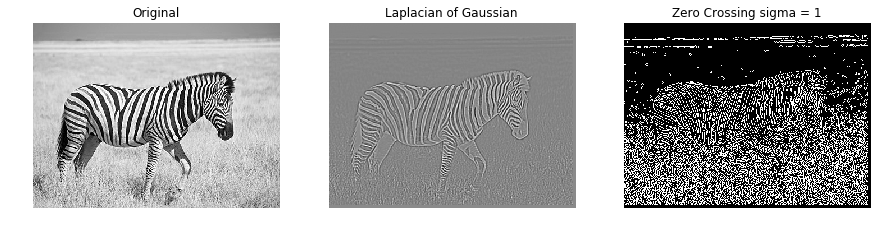

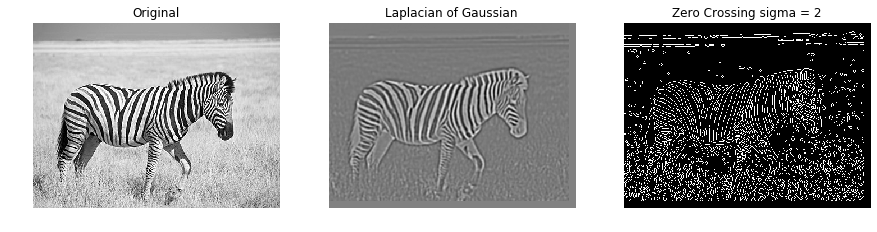

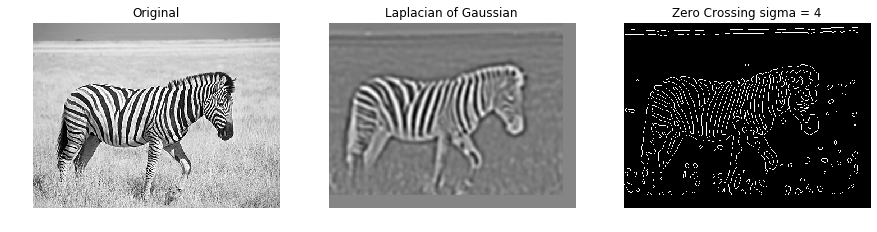

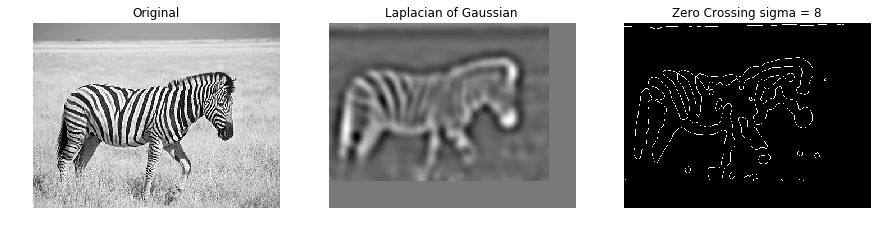

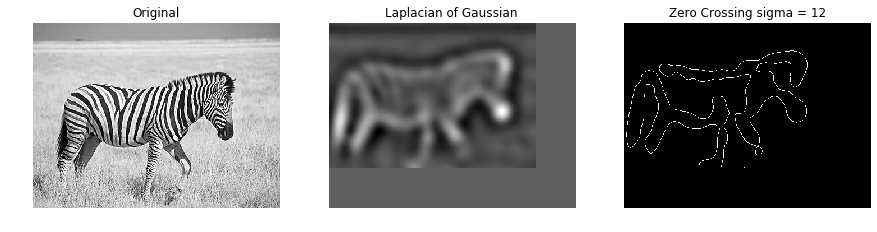

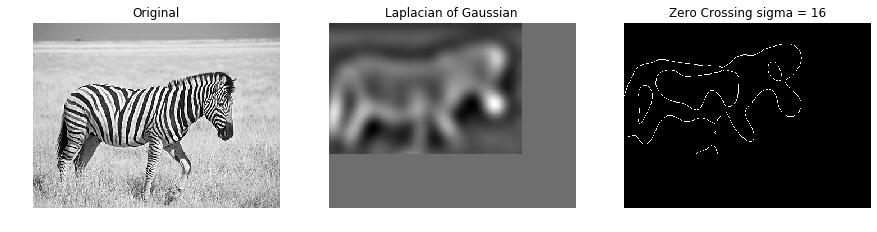

In [111]:
# Plot the Laplacians and the zero-crossings

sigmas = [1,2,4,8,12,16]
img = plt.imread('zebra.jpg')[:,:,0]

for sigma in sigmas:
    b = get_edges_Marr_Hildreth(img, sigma=sigma)

## Canny Edge Detector

In [121]:
def cannyEdge(im, sigma, th1, th2):
    """
    function finds the edges using Canny edge detection method...
    :param im:input image
    :param sigma: sigma is the std-deviation and refers to spread of gaussian
    :param th1:low threshold used to identify weak edges...
    :param th2: high threshold used to identify strong edges...
    :return:
    a binary edge image...
    """

    size = int(2*(np.ceil(3*sigma))+1)

    x, y = np.meshgrid(np.arange(-size/2+1, size/2+1), np.arange(-size/2+1, size/2+1))

    normal = 1 / (2.0 * np.pi * sigma**2)

    kernel = np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal # calculating gaussian filter

    kern_size, gauss = kernel.shape[0], np.zeros_like(img, dtype=float)

    for i in range(img.shape[0]-(kern_size-1)):
        for j in range(img.shape[1]-(kern_size-1)):
            window = img[i:i+kern_size, j:j+kern_size] * kernel
            gauss[i,j] = np.sum(window)

    kernel, kern_size = np.array([[-1,-1,-1],[0,0,0],[1,1,1]]), 3 # edge detection
    gx, gy = np.zeros_like(gauss, dtype=float), np.zeros_like(gauss, dtype=float)

    for i in range(gauss.shape[0]-(kern_size-1)):
        for j in range(gauss.shape[1]-(kern_size-1)):
            window = gauss[i:i+kern_size, j:j+kern_size] 
            gx[i,j], gy[i,j] = np.sum(window * kernel.T), np.sum(window * kernel)
            
    magnitude = np.sqrt(gx**2 + gy**2)
    theta = ((np.arctan(gy/gx))/np.pi) * 180 # radian to degree conversion
    nms = np.copy(magnitude)

    theta[theta<0] += 180

    # non maximum suppression; quantization and suppression done in same step
    for i in range(theta.shape[0]-(kern_size-1)):
        for j in range(theta.shape[1]-(kern_size-1)):
            if (theta[i,j]<=22.5 or theta[i,j]>157.5):
                if(magnitude[i,j]<=magnitude[i-1,j]) and (magnitude[i,j]<=magnitude[i+1,j]): nms[i,j]=0
            if (theta[i,j]>22.5 and theta[i,j]<=67.5):
                if(magnitude[i,j]<=magnitude[i-1,j-1]) and (magnitude[i,j]<=magnitude[i+1,j+1]): nms[i,j]=0
            if (theta[i,j]>67.5 and theta[i,j]<=112.5):
                if(magnitude[i,j]<=magnitude[i+1,j+1]) and (magnitude[i,j]<=magnitude[i-1,j-1]): nms[i,j]=0
            if (theta[i,j]>112.5 and theta[i,j]<=157.5):
                if(magnitude[i,j]<=magnitude[i+1,j-1]) and (magnitude[i,j]<=magnitude[i-1,j+1]): nms[i,j]=0
    

    weak, strong = np.copy(nms), np.copy(nms)

    # weak edges
    weak[weak<th1] = 0
    weak[weak>th1] = 1

    # strong edges
    strong[strong<th2] = 0
    strong[strong>th2] = 1

    # plotting multiple images
    fig = plt.figure(figsize=(15,5))
    a=fig.add_subplot(1,4,1)
    imgplot = plt.imshow(gauss, cmap='gray')
    a.set_title('Gaussian')
    a=fig.add_subplot(1,4,2)
    imgplot = plt.imshow(magnitude, cmap='gray')
    a.set_title('Magnitude')	
    a=fig.add_subplot(1,4,3)
    imgplot = plt.imshow(weak, cmap='gray')
    a.set_title('Weak edges')
    a=fig.add_subplot(1,4,4)
    imgplot = plt.imshow(255-strong, cmap='gray')
    a.set_title('Strong edges')
    plt.show()

/miniconda2/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/miniconda2/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/miniconda2/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in arctan
/miniconda2/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less


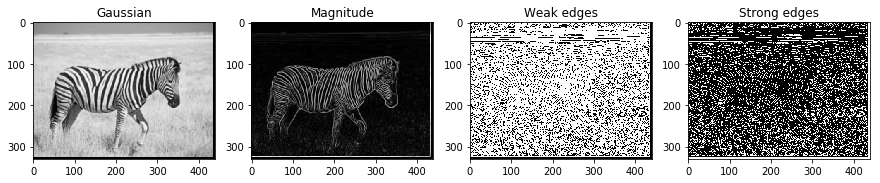

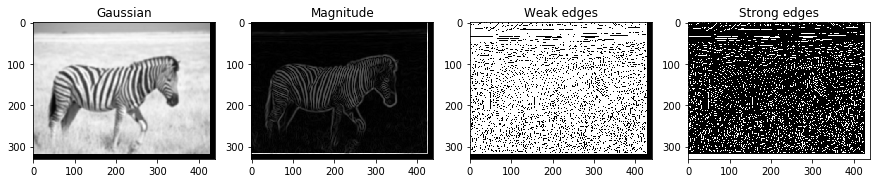

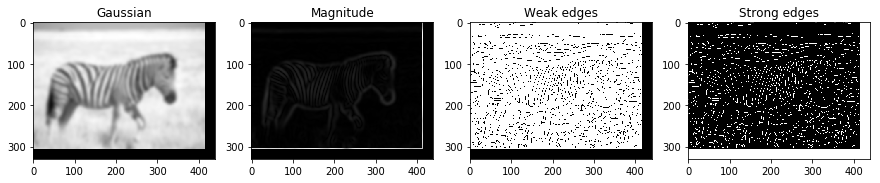

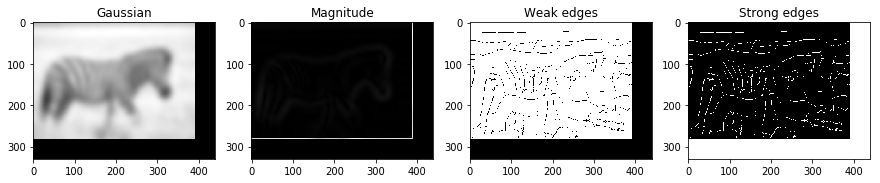

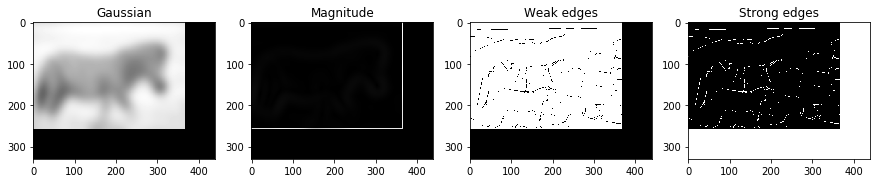

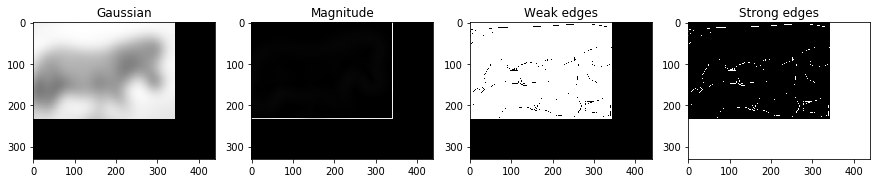

In [125]:
# Plot the Laplacians and the zero-crossings

sigmas = [1,2,4,8,12,16]
img = plt.imread('zebra.jpg')[:,:,0]
th1 = 10; th2=.2
for sigma in sigmas:
    b = cannyEdge(img, sigma, th1, th2)